<a href="https://colab.research.google.com/github/frtendero/ACRIA-LOAD-TEST/blob/master/tf_images_custom_retina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Load images Retina

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/images"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This is a notebook based on the tensorflow tutorial provides a simple example of how to load an image dataset using `tf.data`.

The dataset used in the tutorial example is distributed as directories of images, with one class of image per directory.

The one used here has a different structure. All images are located in the data folder, and an additional excel file contains a table with the name of the image and its label. 

## Setup

In [0]:
import tensorflow as tf

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # automatic optimization of number of calls

In [0]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [0]:
tf.__version__

### Retrieve the images

Before you start any training, you will need a set of images to teach the network about the new classes you want to recognize. You can use an archive of creative-commons licensed flower photos from Google.

__A small subsample of the Retina dataset is used instead__.

Data is located in google drive, so let's mount it and change to the project dir.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
%cd '/content/gdrive/My Drive/ACRIA'

In [49]:
%ls

data/  Labels.xlsx  load_data.py  model_1.py  Models.xlsx


## Load using `tf.data`

The above `keras.preprocessing` method is convienient, but has three downsides: 

1. It's slow. See the performance section below.
1. It lacks fine-grained control.
1. It is not well integrated with the rest of TensorFlow.

Therefore, ```tf.data``` is the prefered option.

Path to images is defined and a ```pathlib.PosixPath``` (_look info about it_) instance with the data directory is defined

In [0]:
import pathlib

data_dir_name = 'data/'

data_dir = pathlib.Path(data_dir_name)
data_dir.is_dir()

We can count the number of images in the directory:

In [30]:
image_count = len(list(data_dir.glob('*.jpeg')))
image_count   # should be: 96

96

Let's display some images:

data/3895.jpeg


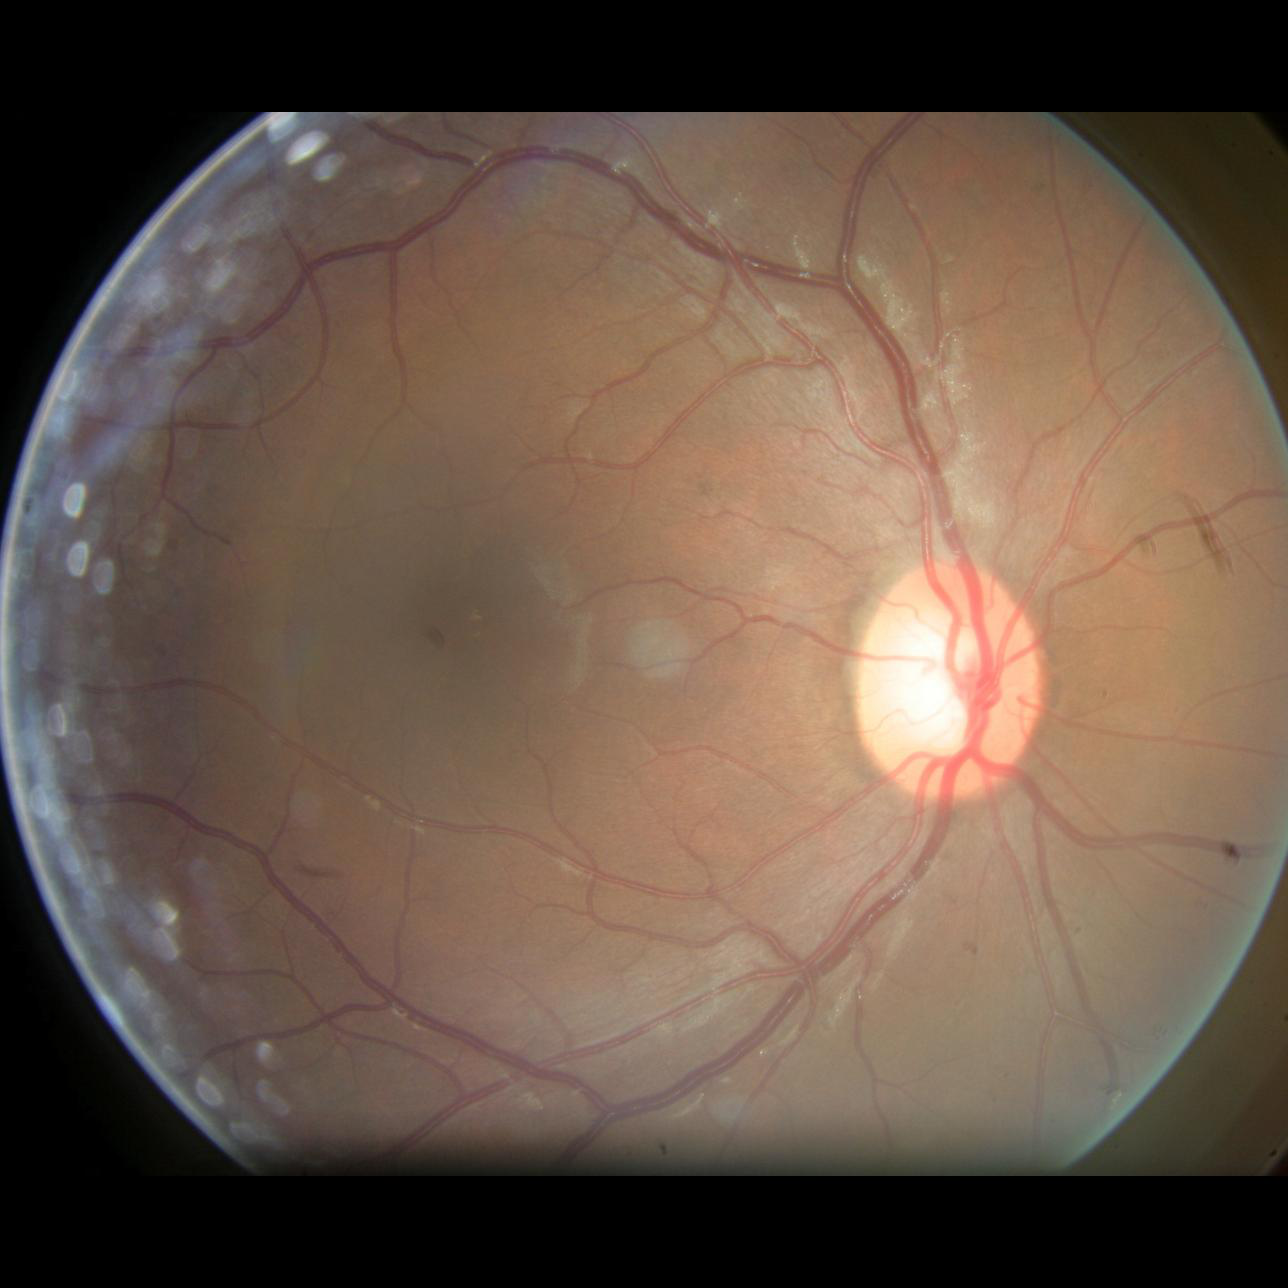

data/4295.jpeg


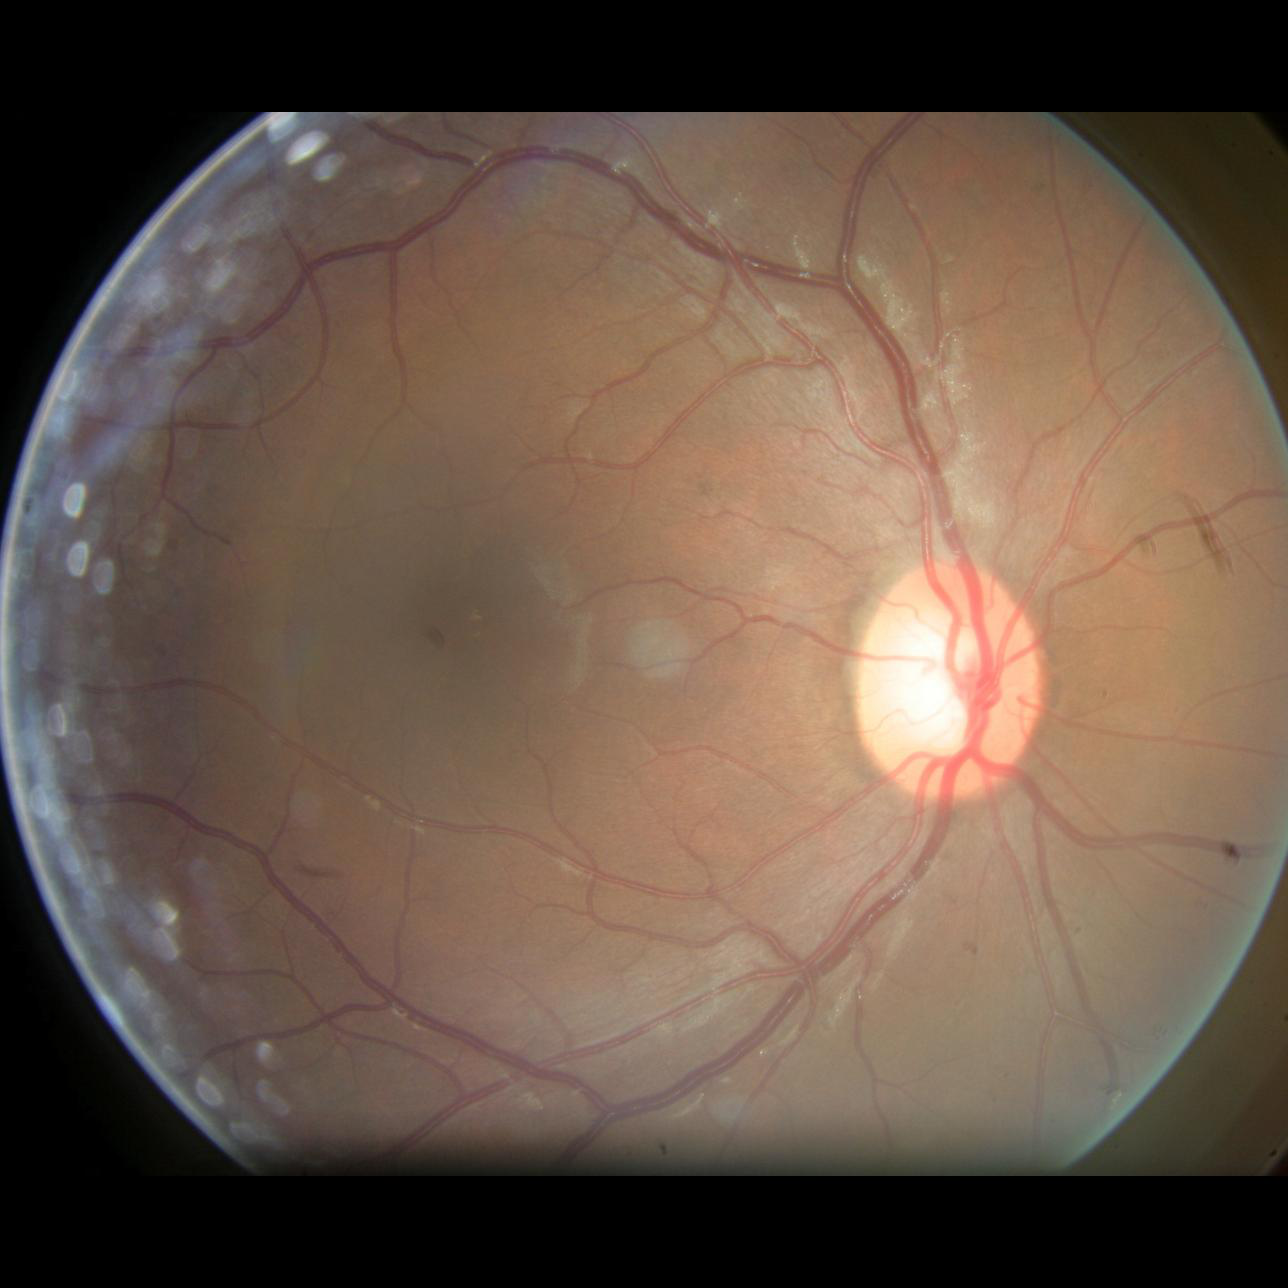

In [37]:
for image_path in list(data_dir.glob('*'))[:2]:
  print(image_path)
  display.display(Image.open(str(test_image)))

### Use of `tf.data`

First, a `tf.data.Dataset`of the file path is created.

In [33]:
# Note that list_ds uses data_dir string ('data/*'), and not the pathlib object
list_ds = tf.data.Dataset.list_files(data_dir_name + '*')
for f in list_ds.take(5):
  print(f.numpy())

b'data/3884.jpeg'
b'data/1408.jpeg'
b'data/4037.jpeg'
b'data/4298.jpeg'
b'data/4187.jpeg'


We want now to create a pure-tensorflow that converts the images file path and the xlsx labels file to an `(img, label)` pair.

__NOTE__ here that, unlike in the `tf` tutorial, instead of a subfolder for labels structure, we have to deal with a xlsx file where the corresponding label to each image is included.

In [0]:
import pandas as pd

In [0]:
IMG_WIDTH, IMG_HEIGHT = 1288, 1288

def decode_image(img):

  # Conver the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)

  # Conver to floats in a [0, 1] scaled range (same effect as typical ./255)
  img = tf.image.convert_image_dtype(img, tf.float32)

  # resize image to desired size
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def get_label(labels_path, n_images=None):
  """ Retrieve a dataframe with the Image ID and its corresponding label """

  # Read xls file:
  read_data = pd.read_excel(labels_path)
  labels_df = read_data[['Classification', 'idImage']]

  labels_df = labels_df.dropna(how = 'any') # drop images withot classification
  labels_df['Classification'] = labels_df['Classification'].apply(lambda x: int(x)) # convert labels to ints
  labels_df = labels_df.loc[(labels_df['Classification'] >= 0) & (labels_df['Classification'] < 3)] # remove defective images (label = -1) and cat 3

  if n_images is not None:
      labels_df = labels_df.loc[labels_df['Image_Name'] <= n_images] # get the selected number of images

  return labels_df

In [0]:
def process_path(file_path):

  # Load label from the name of the image (number)
  labels_df = get_label("Labels.xlsx")

  # Load the raw data from the file as string
  img = tf.io.read_file(file_path)

  # TODO: What is that? TRY TO PRINT 'parts' & 'parts[-2]' @ original NB
  parts = tf.strings.split(file_path, os.path.sep)
  print(parts)
  print(parts[-1])

  # TODO: FROM HERE: HOW TO DETECT THE IMAGE NAME? File path is a tensor!
  print(f"\nfile path: {file_path}")
  print(f"\nimg before decoding: {img}")

  # TODO: HOW TO REFER THE FILE NAME?
  label = labels_df[labels_df["idImage"] == file_path]["Classification"]
  print(f"\nlabel: {label}")

  # decode the 'jpeg' image using the implemented function above
  img = decode_image(img)

  # return the pair of 'decoded image' & 'label'
  return img, label

In [105]:
# Parallelize data loading using AUTOTNE and using map to create dataset of image, label pairs
# NOTE: Since list_ds is already a ts.dataset, it doesn't need to especify the filepath argument
print("\nProcessing path images ...")
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


Processing path images ...
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tensor("strided_slice:0", shape=(), dtype=string)

file path: Tensor("args_0:0", shape=(), dtype=string)

img before decoding: Tensor("ReadFile:0", shape=(), dtype=string)

label: Series([], Name: Classification, dtype: int64)


In [78]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

# We are getting the image good, but not the label

Image shape:  (1288, 1288, 3)
Label:  []


In [70]:
# testing labels xlsx loading ...
%ls
# pd.read_excel('Labels.xlsx')

data/  Labels.xlsx  load_data.py  model_1.py  Models.xlsx



TODO:
- Pass excel as arguments
- Transform labels data frame to a tensorflow dataset, in order to perform the
image id and label mapping with better performance.
- Program a script to transfrom file structure to 'data/{label1, label2, ..}/{1, 2, 3, ...}'

In [68]:
labeled_ds

<ParallelMapDataset shapes: ((1288, 1288, 3), (0, 2)), types: (tf.float32, tf.int64)>

## Load using `keras.preprocessing`

A simple way to load images is to use `tf.keras.preprocessing`.

In [0]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Define some parameters for the loader:

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [0]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Inspect a batch:

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [0]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

To load the files as a `tf.data.Dataset` first create a dataset of the file paths:

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
list_ds

In [0]:
for f in list_ds.take(5):
  print("\n", type(f))
  print(f.numpy())

Write a short pure-tensorflow function that converts a file path to an `(img, label)` pair:

In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [0]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

### Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

type(image_batch)

In [0]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Performance

Note: This section just shows a couple of easy tricks that may help performance. For an in depth guide see [Input Pipeline Performance](../../guide/performance/datasets).

To investigate, first here's a function to check the performance of our datasets:

In [0]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

Let's compare the speed of the two data generators:

In [0]:
# `keras.preprocessing`
timeit(train_data_gen)

In [0]:
# `tf.data`
timeit(train_ds)

A large part of the performance gain comes from the use of `.cache`.

In [0]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

If the dataset doesn't fit in memory use a cache file to maintain some of the advantages:

In [0]:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)